In [71]:
using Agents
using Graphs
using DynamicalSystems
using InteractiveDynamics
using GLMakie
using CairoMakie
using GraphMakie
using Karnak, Luxor, Colors
using NetworkLayout
using Plots
using StatsPlots

using Random
using Measures
using Compose, Cairo, Fontconfig
using LaTeXStrings
using StatsBase

using LinearAlgebra
using DataFrames
using Statistics

### Create Graph Space

In [2]:
SEED = 123

# set up the dims of grid
const NN = 13
const GRID_DIM = (NN,NN)

# agent num = 75% of the node
TOTAL_AGENTS = round( Int, 0.75*prod(GRID_DIM) );

In [3]:
# Randomly deciding whether to add or remove edges to simulates the dynamic alteration of edges in the graph

function DiffEdgesGraphs(NN, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)
    GRID_DIM = (NN,NN)
    graph = Graphs.grid(GRID_DIM, periodic=false)
    
    for source_node in vertices(graph)

        # add edge
        if( rand() < THRESHOLD_RAND_EDGE_ADD )
            destination_node = rand( 1:nv(graph), 1)[1]

            if( destination_node != source_node )
                add_edge!(graph, source_node, destination_node)
            end
        end

        # remove edge
        if( rand() < THRESHOLD_RAND_EDGE_RM )
            neighbors = all_neighbors(graph, source_node)

            if( length(neighbors) > 0 )
                neighbor = rand( neighbors, 1)[1]
                rem_edge!(graph, source_node, neighbor)
            end
        end
    end
    return graph
end

DiffEdgesGraphs (generic function with 1 method)

### Model initial function

In [4]:
# Define Agent
@agent GraphSchellingAgent GraphAgent begin
    remain::Union{Number ,Bool}
    group::Int
end

In [5]:
rng1 = Random.Xoshiro(SEED)

Xoshiro(0xfefa8d41b8f5dca5, 0xf80cc98e147960c1, 0x20e2ccc17662fc1d, 0xea7a7dcb2e787c01)

In [6]:
# Initialize the model based on graph

function initialize(graph)
    global model_iteration = 0
    
    space = GraphSpace(graph)
    
    # The properties in model will now hold the min remain percentage = 0.5
    properties = Dict( :min_remain_percentage => 0.5 )
    
    # Set model as unremovable agent based model
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=rng1, scheduler=Schedulers.Randomly() )
    
    agent_num = round( Int, 0.75*prod(nv(graph)) )
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:agent_num
        remain_temp = false
        group_temp = agent_ind < agent_num/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

initialize (generic function with 1 method)

### Agent step

This part is to define how we decide if the agent is going to move to next positoin based on the homogeneity and if they will be satisfy

In [7]:
# Get the position's nearby info include num of nearby position and homogeneity. 
# Can be use to get current agent & next positoin's nearby info

function PositionStatus(group, position, model)
    count_near = 0
    for pos in nearby_positions(position, model,1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for id in nearby_ids( position, model , 1)
        agent = model[id]
        if agent.group == group
            count_neighbors_same_group += 1
        end
    end
    
    return [count_near, count_neighbors_same_group]
    
end

PositionStatus (generic function with 1 method)

In [8]:
# Caculate the urban level
# Reason: to prevent agent get into bad cycle because they move to a less connect hub(position that have less edges)

function NeighborhoodProb(pos_new, model)
    neighbor_num_vec = []
    
    for agent_tmp in allagents(model)
        nearby_num = length(collect(nearby_positions(agent_tmp.pos, model)))
        push!(neighbor_num_vec, nearby_num)
    end
    
    nearby_num = length(collect(nearby_positions(pos_new, model)))
    push!(neighbor_num_vec, nearby_num)
    
    unique_neighbor_num = unique(neighbor_num_vec)
    prob_remain = Dict()
    
    for k in unique_neighbor_num
        prob_remain[k] = 1 - (length(findall(k .< neighbor_num_vec))/length(neighbor_num_vec))
    end
         
    return prob_remain[length(collect(nearby_positions(pos_new, model)))]
end

NeighborhoodProb (generic function with 1 method)

In [9]:
# Decide if the next position would satisfy the agent
function NextPosition(agent, model)
    
    rand_pos = random_empty(model)
    count_near, count_neighbors_same_group = PositionStatus(agent.group, rand_pos, model)
    identify_stat = (count_neighbors_same_group / count_near) >= model.min_remain_percentage 

    # if the homogeneity doesn't satisfy. Reject moving.
    if(identify_stat != true)
        return -1
    end

    neigbor_prob = NeighborhoodProb(rand_pos, model)

    if( Int(identify_stat) * neigbor_prob > rand() ) 
        return rand_pos
    else
        return -1

    end
end

NextPosition (generic function with 1 method)

In [10]:
function agent_step!(agent, model)

    # Get current agent's nearby info
    count_near, count_neighbors_same_group = PositionStatus(agent.group, agent.pos, model)
    
    remain_current = (count_neighbors_same_group / count_near) >= model.min_remain_percentage
    if remain_current == true
        agent.remain = 1
        return 
    end
       
    # Get next posible place's nearby info
    newPosition = NextPosition(agent, model)
    # if newPosition is not -1, means the next position is better than current.
    if newPosition == -1
        agent.remain = 0
        return
    else
        agent.remain = 1
        move_agent!(agent , newPosition, model)
    end

end

agent_step! (generic function with 1 method)

### Entropy Calculation Functions

H(x)=−p(x)ln(p(x))

https://chat.openai.com/share/2f8b5ccf-beee-4bbc-a036-61b9b58245e1

In [11]:
# Get the % of agent stay in their pos
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

# Caculate graph entropy (Trace State) based on agent's group homogeneity
function GraphBaseEntropy(model)
    
    edge_total_num = 0
    agent_degree_distribution = Dict()
        
    for agent in allagents(model)
        edge_num = 0
        
        for near_agent in nearby_agents(agent,model, 1)
           if near_agent.group == agent.group
               edge_num += 1 
            end           
        end
        
        edge_total_num += edge_num
        
        if edge_num in keys(agent_degree_distribution)
            agent_degree_distribution[edge_num] += 1
        else
            agent_degree_distribution[edge_num] = 1
        end    
    end
    
    # Get agent_degree_distribution prob
    for k in keys(agent_degree_distribution)
        agent_degree_distribution[k] /= edge_total_num
    end
    
    #println(agent_degree_distribution)
    H = 0
    
     for k in keys(agent_degree_distribution)
        H += (-1) * agent_degree_distribution[k] * log(agent_degree_distribution[k])
        
    end
    
    return H
end

GraphBaseEntropy (generic function with 1 method)

In [12]:
# Caculate graph entropy(Macro) based on node's connection
function GraphSpaceEntropy(model)
    G = model.space.graph

    node_total_num = nv(G)
    node_dregree_distrubution = Dict()
    
    for v in vertices(G)
        edge_num = length(collect(neighbors(G, v)))
        if edge_num in keys(node_dregree_distrubution)
            node_dregree_distrubution[edge_num] += 1
        else
            node_dregree_distrubution[edge_num] = 1
        end  
    end
    
    for k in keys(node_dregree_distrubution)
        node_dregree_distrubution[k] /= node_total_num
    end
    
    #println(node_dregree_distrubution)
    H = 0
    
    for k in keys(node_dregree_distrubution)
        H += (-1) * node_dregree_distrubution[k] * log(node_dregree_distrubution[k])       
    end

    return H

end

GraphSpaceEntropy (generic function with 1 method)

### Create model on graph space and get model data

In [13]:
# batch generate models based on input grpahs list

function ModelGenerator(graphsList)
    models = []
    for graph in graphsList
        model = initialize(graph)
        push!(models, model)
    end
    return models
end

ModelGenerator (generic function with 1 method)

In [14]:
# Record model's data after agent steps

function ModelDataRecord(init_graphs, step_num, loop_num)
    init_models = ModelGenerator(init_graphs)
    
    # Get the remain%, Entropy based on agent, and Entropy of the whole graph
    mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
    df = []
    remain = []
    graph_base_H =[]
    graph_space_H = []

    for (index, model) in pairs(init_models)

        _, model_df = run!(model, agent_step!, step_num; mdata)

        push!(df, model_df)
        push!(remain, model_df[:,:ModelRemainTrajectory])
        push!(graph_base_H, model_df[:,:GraphBaseEntropy])
        push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
    end
    
    LOOPS = 1:loop_num

    for i in LOOPS
        # initialize models on same graph
        init_models = ModelGenerator(init_graphs)
        for (index, model) in pairs(init_models)

            _, model_df = run!(model, agent_step!, step_num; mdata)
            graph_base_H[index] += model_df[:,:GraphBaseEntropy]
            remain[index] += model_df[:,:ModelRemainTrajectory]
        end
    end
    
    graph_base_H /= 1+length(LOOPS)
    remain /= 1+length(LOOPS)
    
    return remain, graph_base_H, graph_space_H
end

ModelDataRecord (generic function with 1 method)

### Create different graph space

In [78]:
simple_graphs = []
push!(simple_graphs, DiffEdgesGraphs(13, 0.0, 0.0))
push!(simple_graphs, DiffEdgesGraphs(13, 0.0, 0.40))
push!(simple_graphs, DiffEdgesGraphs(13, 0.0, 0.90))
push!(simple_graphs, DiffEdgesGraphs(13, 0.40, 0.0))
push!(simple_graphs, DiffEdgesGraphs(13, 0.90, 0.0))
push!(simple_graphs, DiffEdgesGraphs(13, 0.20, 0.20))
push!(simple_graphs, DiffEdgesGraphs(13, 0.70, 0.70)) 
println(length(simple_graphs))

7


In [79]:
# record data for simple graph with 30 agent steps and 100 loop 

remain, gb_H,gs_H = ModelDataRecord(simple_graphs, 30, 100);

#### Calculate the rho and visualize

In [80]:
HGs = [g[1] for g in gs_H]
HGs = [round(h; digits=3) for h in HGs]
HGstr = [L"H_g="*"$(h)" for h in HGs]
HGstr = permutedims(HGstr)


1×7 Matrix{String}:
 "\$H_g=\$0.678"  "\$H_g=\$1.194"  …  "\$H_g=\$1.346"  "\$H_g=\$1.677"

In [102]:
cor_times = 5

5

In [103]:
remain_ends = [remain[i][cor_times] for i in 1:length(remain)]

s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)

-0.679

In [104]:
entropy_ends = [gb_H[i][cor_times] for i in 1:length(gb_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

-0.214

In [105]:
Statistics.cor(HGs,remain_ends)

-0.5169877342591538

In [106]:
Statistics.cor(HGs,entropy_ends)

0.07720604618622563

In [107]:
# correlat
Statistics.cor(entropy_ends,remain_ends) 

0.7962056981305453

In [108]:
s_score_entropy2 = corspearman(remain_ends, entropy_ends)
s_score_entropy2 = round(s_score_entropy2; digits=3)

0.75

In [20]:
using Measures

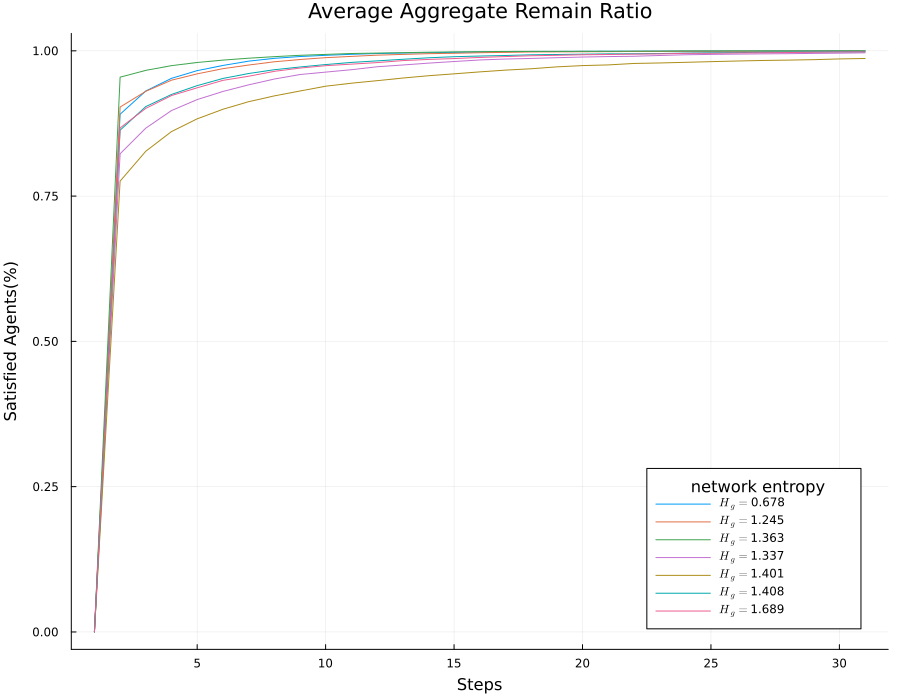

In [21]:
p1 = Plots.plot(remain, xlabel = "Steps",ylabel = "Satisfied Agents(%)",legend=true,labels = HGstr, 
    legendtitle="network entropy",
    title="Average Aggregate Remain Ratio", size=(900, 700), left_margin = 2Measures.mm )
savefig("./plots/Fig1remainSyntheticH.pdf")
display(p1)

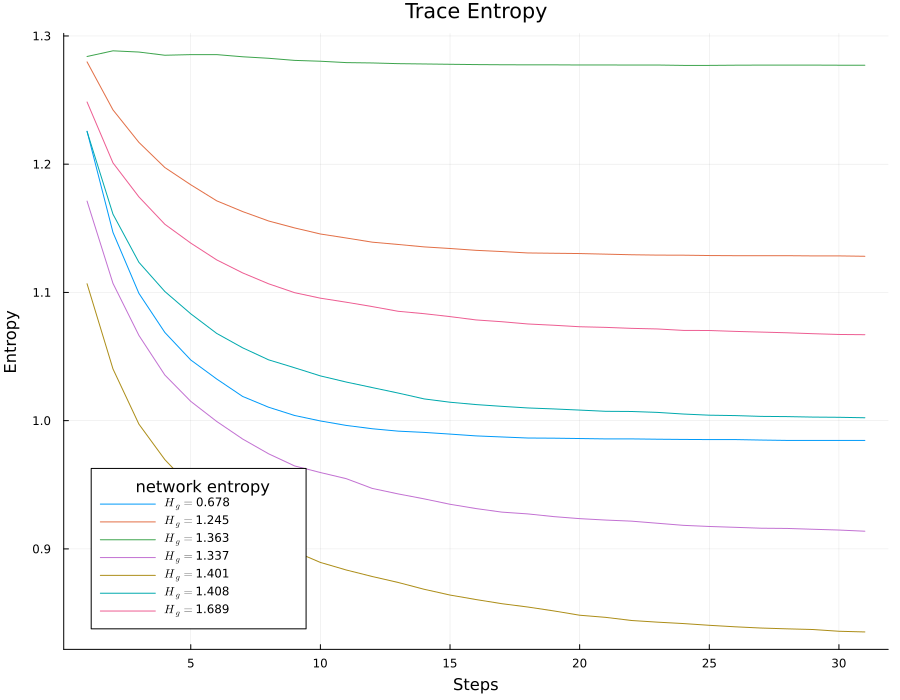

In [22]:
p2 = Plots.plot(gb_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr, legendtitle="network entropy",
    title="Trace Entropy", size=(900, 700), left_margin = 2Measures.mm )
savefig("./plots/Fig2entropySyntheticH.pdf")
display(p2)

### Create different statistification model

In [109]:

function initialize_stay(remain_percentage)
    global model_iteration = 0
    
    graph = DiffEdgesGraphs(13, 0.0, 0.0)
    space = GraphSpace(graph)
    
    # The properties in model will now hold the min remain percentage
    properties = Dict( :min_remain_percentage => remain_percentage )
    
    # Set model as unremovable agent based model
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=rng1, scheduler=Schedulers.Randomly() )
    
    agent_num = round( Int, 0.75*prod(nv(graph)) )
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:agent_num
        remain_temp = false
        group_temp = agent_ind < agent_num/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

stay_graph_models = []

push!(stay_graph_models, initialize_stay(0.1))
push!(stay_graph_models, initialize_stay(0.2))
push!(stay_graph_models, initialize_stay(0.3))
push!(stay_graph_models, initialize_stay(0.4))
push!(stay_graph_models, initialize_stay(0.5))
push!(stay_graph_models, initialize_stay(0.6))
push!(stay_graph_models, initialize_stay(0.7))
push!(stay_graph_models, initialize_stay(0.8))

8-element Vector{Any}:
 UnremovableABM with 127 agents of type GraphSchellingAgent
 space: GraphSpace with 169 positions and 312 edges
 scheduler: Agents.Schedulers.Randomly
 properties: min_remain_percentage
 UnremovableABM with 127 agents of type GraphSchellingAgent
 space: GraphSpace with 169 positions and 312 edges
 scheduler: Agents.Schedulers.Randomly
 properties: min_remain_percentage
 UnremovableABM with 127 agents of type GraphSchellingAgent
 space: GraphSpace with 169 positions and 312 edges
 scheduler: Agents.Schedulers.Randomly
 properties: min_remain_percentage
 UnremovableABM with 127 agents of type GraphSchellingAgent
 space: GraphSpace with 169 positions and 312 edges
 scheduler: Agents.Schedulers.Randomly
 properties: min_remain_percentage
 UnremovableABM with 127 agents of type GraphSchellingAgent
 space: GraphSpace with 169 positions and 312 edges
 scheduler: Agents.Schedulers.Randomly
 properties: min_remain_percentage
 UnremovableABM with 127 agents of type GraphSc

In [110]:
mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
df = []
remain = []
graph_base_H =[]
graph_space_H = []
step_num = 30

for (index, model) in pairs(stay_graph_models)

    _, model_df = run!(model, agent_step!, step_num; mdata)

    push!(df, model_df)
    push!(remain, model_df[:,:ModelRemainTrajectory])
    push!(graph_base_H, model_df[:,:GraphBaseEntropy])
    push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
end

LOOPS = 1:100

for i in LOOPS
    # initialize models on same graph
    stay_graph_models = []

    push!(stay_graph_models, initialize_stay(0.1))
    push!(stay_graph_models, initialize_stay(0.2))
    push!(stay_graph_models, initialize_stay(0.3))
    push!(stay_graph_models, initialize_stay(0.4))
    push!(stay_graph_models, initialize_stay(0.5))
    push!(stay_graph_models, initialize_stay(0.6))
    push!(stay_graph_models, initialize_stay(0.7))
    push!(stay_graph_models, initialize_stay(0.8))
    for (index, model) in pairs(stay_graph_models)

        _, model_df = run!(model, agent_step!, step_num; mdata)
        graph_base_H[index] += model_df[:,:GraphBaseEntropy]
        remain[index] += model_df[:,:ModelRemainTrajectory]
    end
end

graph_base_H /= 1+length(LOOPS)
remain /= 1+length(LOOPS);

In [111]:
HGs = [g[1] for g in graph_space_H]
HGs = [round(h; digits=3) for h in HGs]
HGstr = [L"H_{0.2}="*"$(HGs[1])",L"H_{0.3}="*"$(HGs[1])", L"H_{0.4}="*"$(HGs[2])",L"H_{0.5}="*"$(HGs[3])",L"H_{0.6}="*"$(HGs[4])",L"H_{0.7}="*"$(HGs[5])"]
HGstr = permutedims(HGstr)

1×6 Matrix{String}:
 "\$H_{0.2}=\$0.678"  "\$H_{0.3}=\$0.678"  …  "\$H_{0.7}=\$0.678"

In [123]:
cor_times = 5

5

In [124]:
remain_ends = [remain[i][cor_times] for i in 1:length(remain)]
print(remain_ends)
s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)

[1.0, 1.0, 0.9820690730490376, 0.9647618305137591, 0.969283542527481, 0.7999532236688232, 0.720745302876744, 0.4524050830279877]

NaN

In [125]:
entropy_ends = [graph_base_H[i][cor_times] for i in 1:length(graph_base_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

NaN

In [126]:
corspearman(entropy_ends, remain_ends)

0.39521666643137543

In [127]:
cor(entropy_ends, remain_ends)

0.002660958626599024

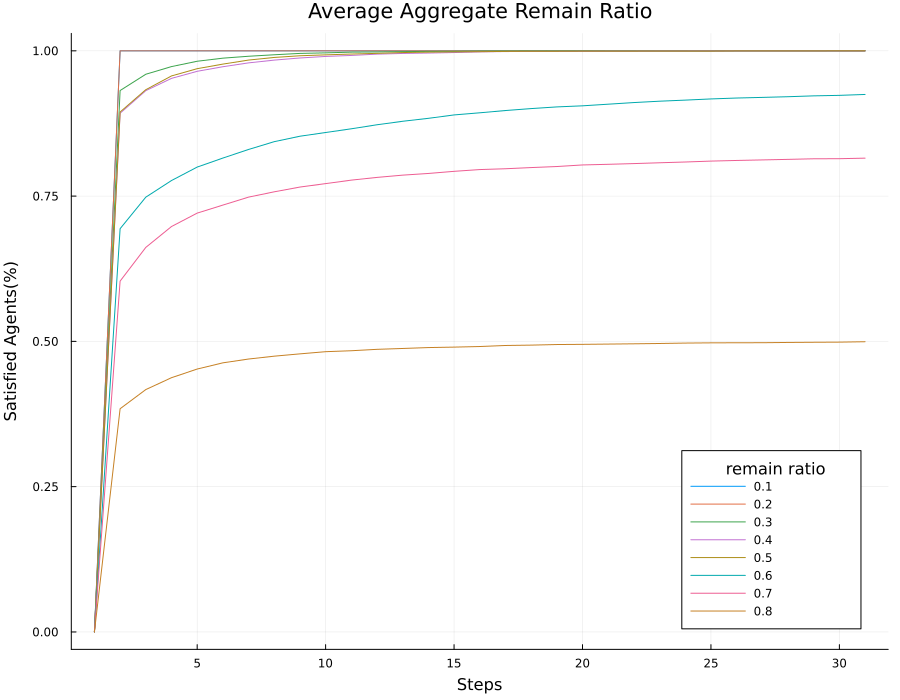

In [117]:
p3 = Plots.plot(remain, xlabel = "Steps",ylabel = "Satisfied Agents(%)",legend=true,labels=collect(0.1:0.1:0.8)',
    legendtitle="remain ratio",
    title="Average Aggregate Remain Ratio", size=(900, 700) , left_margin = 2Measures.mm )
savefig("./plots/Fig3remainProbExplore.pdf")
display(p3)

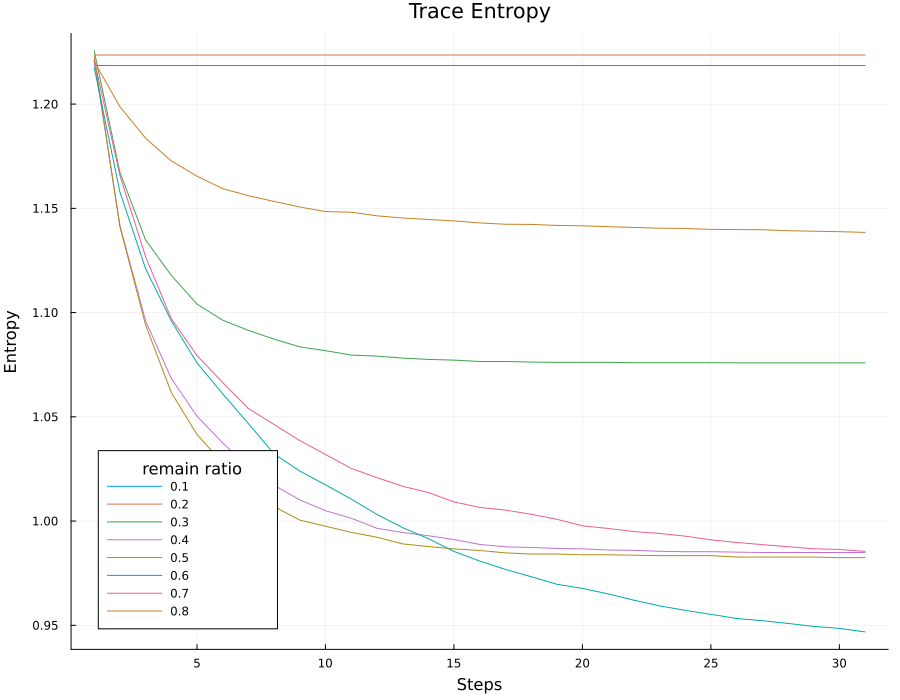

In [118]:
p4 = Plots.plot(graph_base_H, xlabel = "Steps",ylabel = "Entropy",legend=true,labels=collect(0.1:0.1:0.8)',
     legendtitle="remain ratio",
    title="Trace Entropy", size=(900, 700) , left_margin = 2Measures.mm )
savefig("./plots/Fig4entropyProbExplore.pdf")
display(p4)

### Create different network types of graphs

Barabasi Albert
Scale Free
Random

In [128]:
num_nodes = prod(GRID_DIM)
num_edges = ne(simple_graphs[1])
num_hub = 1
barabasi_albert_residential_graph_1 = Graphs.barabasi_albert(num_nodes, 5)
barabasi_albert_residential_graph_2 = Graphs.barabasi_albert(num_nodes, 3)

{169, 498} undirected simple Int64 graph

In [129]:
scale_free_residential_graph_1 = Graphs.static_scale_free(num_nodes,num_edges,2)
scale_free_residential_graph_2 = Graphs.static_scale_free(num_nodes,num_edges,3)

{169, 312} undirected simple Int64 graph

In [130]:
random_residential_graph = Graphs.random_regular_graph(num_nodes, 4)

{169, 338} undirected simple Int64 graph

In [131]:
newman_watts_strogatz_residential_graph = Graphs.newman_watts_strogatz(num_nodes, 4, 0.3)

{169, 438} undirected simple Int64 graph

In [132]:
diff_network_graphs = []

push!(diff_network_graphs, barabasi_albert_residential_graph_1)
push!(diff_network_graphs, barabasi_albert_residential_graph_2)
push!(diff_network_graphs, scale_free_residential_graph_1)
push!(diff_network_graphs, scale_free_residential_graph_2)
push!(diff_network_graphs, newman_watts_strogatz_residential_graph)
push!(diff_network_graphs, DiffEdgesGraphs(13, 0.0, 0.0))

6-element Vector{Any}:
 {169, 820} undirected simple Int64 graph
 {169, 498} undirected simple Int64 graph
 {169, 312} undirected simple Int64 graph
 {169, 312} undirected simple Int64 graph
 {169, 438} undirected simple Int64 graph
 {169, 312} undirected simple Int64 graph

In [133]:
# record data for simple graph with 30 agent steps and 100 loop 
network_remain, network_gb_H, network_gs_H = ModelDataRecord(diff_network_graphs, 30, 100);

#### Calculate the rho and visualize

In [134]:
HGs = [g[1] for g in network_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{BA1}="*"$(HGs[1])", L"H_{BA2}="*"$(HGs[2])",L"H_{SF1}="*"$(HGs[3])", L"H_{SF2}="*"$(HGs[4])",L"H_{NWS}="*"$(HGs[5])", L"H_{Grid}="*"$(HGs[6])"]
HGstr = permutedims(HGstr)

1×6 Matrix{String}:
 "\$H_{BA1}=\$2.368"  "\$H_{BA2}=\$1.959"  …  "\$H_{Grid}=\$0.678"

In [167]:
cor_times = 5

5

In [168]:
network_remain_ends = [network_remain[i][cor_times] for i in 1:length(network_remain)]

s_score_remain = corspearman(HGs, network_remain_ends)
s_score_remain = round(s_score_remain; digits=3)

-0.486

In [169]:
entropy_ends = [network_gb_H[i][cor_times] for i in 1:length(network_gb_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

-0.086

In [170]:
corspearman(network_remain_ends, entropy_ends)

0.7142857142857143

In [171]:
cor(network_remain_ends, entropy_ends)

0.6725513278234696

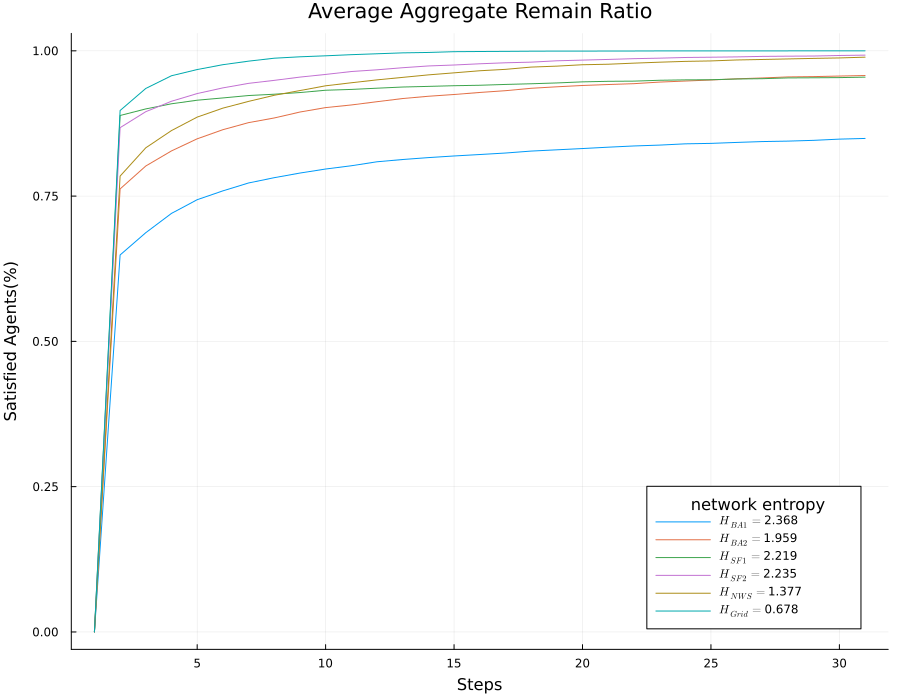

In [137]:
p5 = Plots.plot(network_remain, xlabel = "Steps",ylabel = "Satisfied Agents(%)",
    legend=true, legendtitle="network entropy", labels = HGstr, 
    title="Average Aggregate Remain Ratio", size=(900, 700) , left_margin = 2Measures.mm )
savefig("./plots/Fig5remainNetworks.pdf")
display(p5)

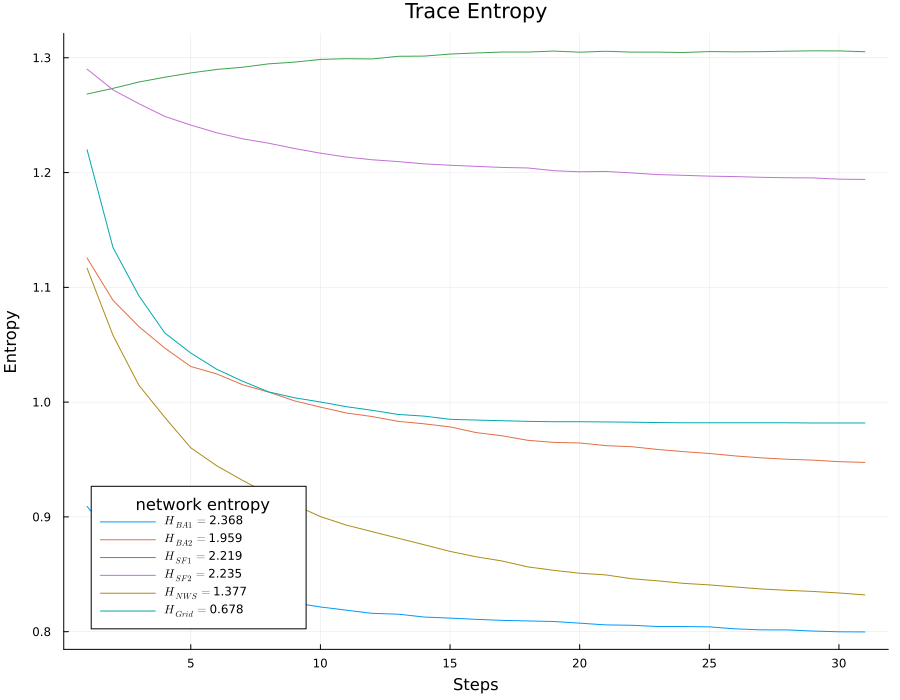

In [138]:
p6 = Plots.plot(network_gb_H, xlabel = "Steps",ylabel = "Entropy",legend=true, 
    labels = HGstr,title="Trace Entropy", legendtitle="network entropy" ,
    size=(900, 700),left_margin = 2Measures.mm )
savefig("./plots/Fig6entropyNetworks.pdf")
display(p6)

### Download OpenStreetMap Network

In [172]:
using OpenStreetMapX
ucf_map_data = get_map_data("ucfmap.osm");
tokyo_map_data = get_map_data("tokyo_map.osm");
tampa_map_data = get_map_data("tampa_map.osm")
miami_map_data = get_map_data("miami_map.osm")
jackson_map_data = get_map_data("jacksonville_map.osm")
beijing_map_data = get_map_data("beijing_map.osm")
washington_map_data = get_map_data("washington_map.osm")

ucf_graph = SimpleGraph(ucf_map_data.g)
tokyo_graph = SimpleGraph(tokyo_map_data.g)
washington_graph = SimpleGraph(washington_map_data.g)
beijing_graph = SimpleGraph(beijing_map_data.g)
jackson_graph = SimpleGraph(jackson_map_data.g)
miami_graph = SimpleGraph(miami_map_data.g)
tampa_graph = SimpleGraph(tampa_map_data.g)

[ Info: Read map data from cache ucfmap.osm.cache
[ Info: Read map data from cache tokyo_map.osm.cache
[ Info: Read map data from cache tampa_map.osm.cache
[ Info: Read map data from cache miami_map.osm.cache
[ Info: Read map data from cache jacksonville_map.osm.cache
[ Info: Read map data from cache beijing_map.osm.cache
[ Info: Read map data from cache washington_map.osm.cache


{1411, 1718} undirected simple Int64 graph

In [173]:
capitial_map_graphs = []

push!(capitial_map_graphs, DiffEdgesGraphs(34, 0.0, 0.0))
push!(capitial_map_graphs, beijing_graph)
push!(capitial_map_graphs, tokyo_graph)
push!(capitial_map_graphs, washington_graph)

4-element Vector{Any}:
 {1156, 2244} undirected simple Int64 graph
 {2080, 2733} undirected simple Int64 graph
 {2029, 2870} undirected simple Int64 graph
 {1126, 1448} undirected simple Int64 graph

In [174]:
# record data for capital openstreet map graph with 30 agent steps and 100 loop 
capital_map_remain, capital_map_gb_H, capital_map_gs_H = ModelDataRecord(capitial_map_graphs, 30, 100);

In [175]:
HGs = [g[1] for g in capital_map_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{Baseline}="*"$(HGs[1])", L"H_{beijing}="*"$(HGs[2])",L"H_{tokyo}="*"$(HGs[3])",L"H_{washington}="*"$(HGs[4])"]
HGstr = permutedims(HGstr)

1×4 Matrix{String}:
 "\$H_{Baseline}=\$0.371"  …  "\$H_{washington}=\$1.427"

In [185]:
cor_times = 5

5

In [186]:
remain_ends = [capital_map_remain[i][cor_times] for i in 1:length(capital_map_remain)]

s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)

-0.4

In [187]:
entropy_ends = [capital_map_gb_H[i][cor_times] for i in 1:length(capital_map_gb_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

0.8

In [188]:
corspearman(remain_ends, entropy_ends)

-0.2

In [189]:
cor(remain_ends, entropy_ends)

-0.7704016645081784

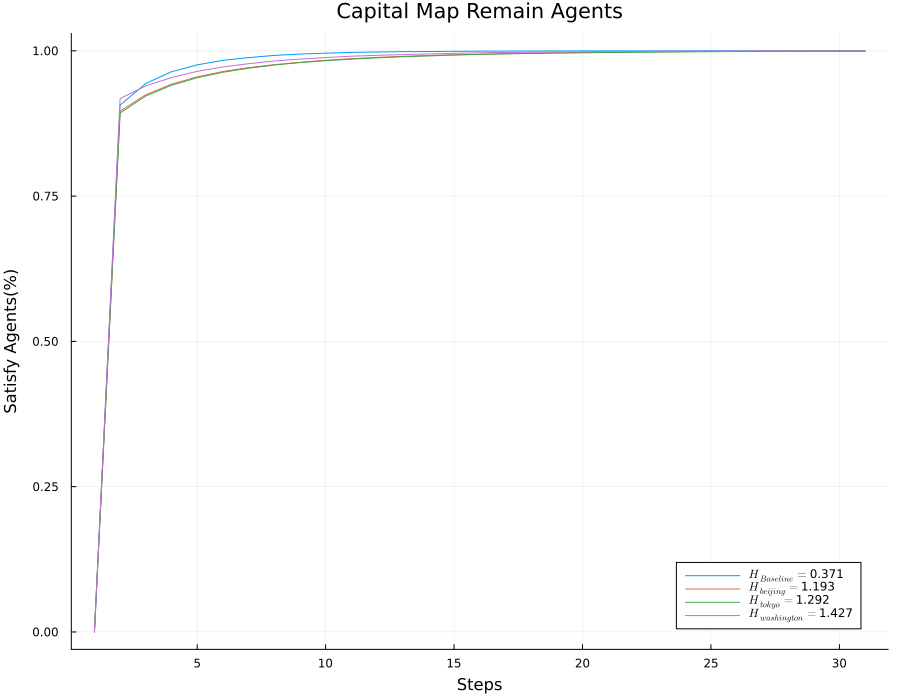

In [178]:
p7 = Plots.plot(capital_map_remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",
    legend=true,labels = HGstr, 
    title="Capital Map Remain Agents", size=(900, 700), left_margin = 2Measures.mm )
savefig("./plots/Fig7remainCapitals.pdf")
display(p7)

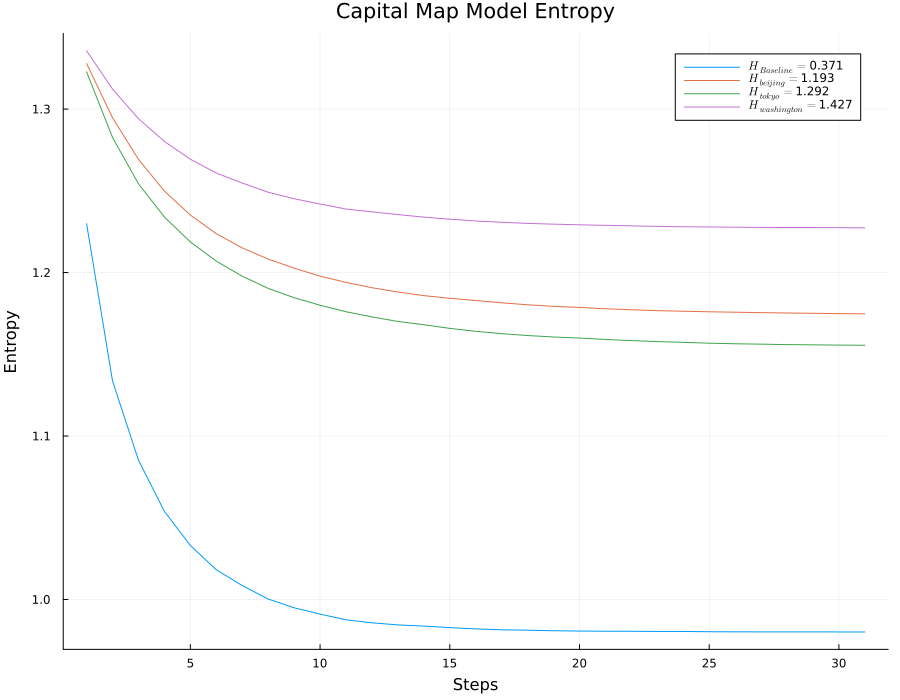

In [179]:
p8 = Plots.plot(capital_map_gb_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,
    title="Capital Map Model Entropy", size=(900, 700), left_margin = 2Measures.mm )
savefig("./plots/Fig8entropyCapitals.pdf")
display(p8)

In [190]:
city_map_graphs = []

push!(city_map_graphs, DiffEdgesGraphs(34, 0.0, 0.0))
push!(city_map_graphs, jackson_graph)
push!(city_map_graphs, miami_graph)
push!(city_map_graphs, tampa_graph)

4-element Vector{Any}:
 {1156, 2244} undirected simple Int64 graph
 {1497, 1943} undirected simple Int64 graph
 {1170, 1451} undirected simple Int64 graph
 {1411, 1718} undirected simple Int64 graph

In [191]:
# record data for cities openstreet map graph with 30 agent steps and 100 loop 
city_map_remain, city_map_gb_H, city_map_gs_H = ModelDataRecord(city_map_graphs, 30, 100);

In [192]:
HGs = [g[1] for g in city_map_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{Baseline}="*"$(HGs[1])", L"H_{Jackson}="*"$(HGs[2])",L"H_{Miami}="*"$(HGs[3])",L"H_{Tampa}="*"$(HGs[4])"]
HGstr = permutedims(HGstr)

1×4 Matrix{String}:
 "\$H_{Baseline}=\$0.371"  "\$H_{Jackson}=\$1.268"  …  "\$H_{Tampa}=\$1.274"

In [193]:
cor_times = 5

5

In [194]:
remain_ends = [city_map_remain[i][cor_times] for i in 1:length(city_map_remain)]

s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)

-0.4

In [195]:
entropy_ends = [city_map_gb_H[i][cor_times] for i in 1:length(city_map_gb_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

0.8

In [196]:
corspearman(remain_ends, entropy_ends)

-0.2

In [197]:
cor(remain_ends, entropy_ends)

-0.9224322345489355

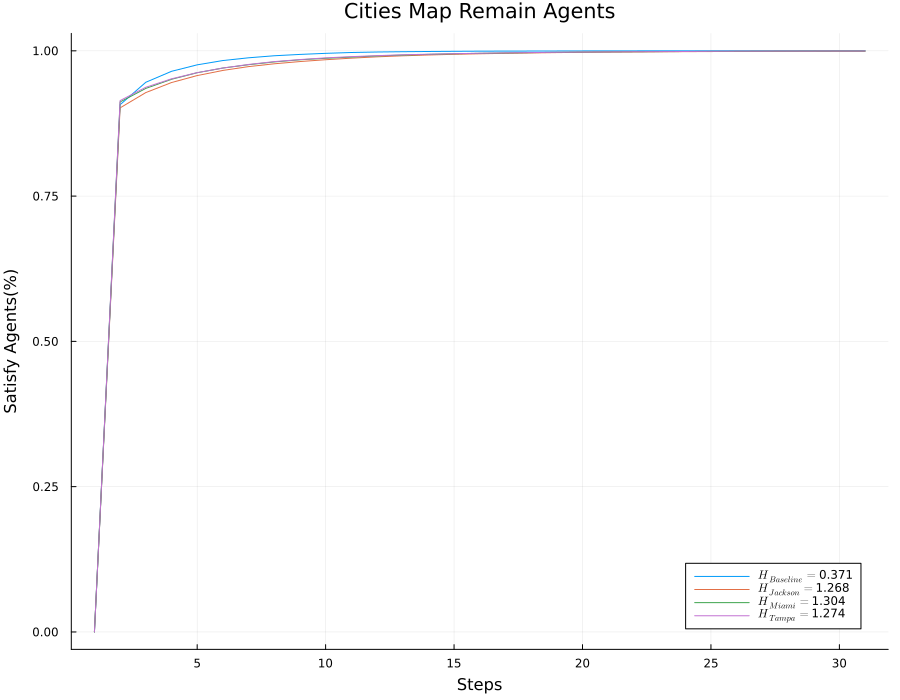

In [198]:
p9 = Plots.plot(city_map_remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, 
    title="Cities Map Remain Agents", size=(900, 700), left_margin = 2Measures.mm )
savefig("./plots/Fig9remainCities.pdf")
display(p9)

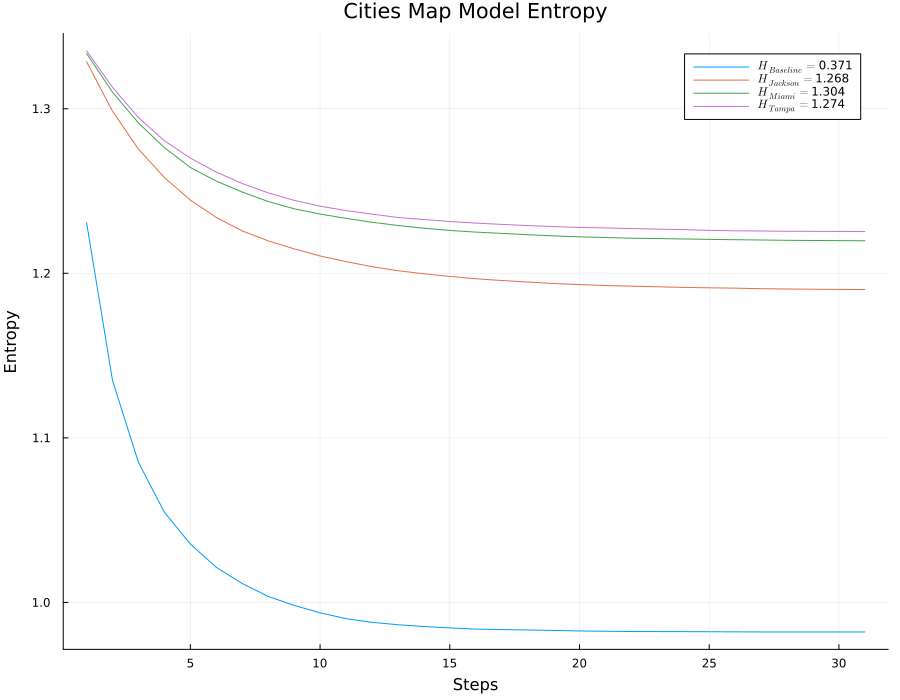

In [199]:
p10 = Plots.plot(city_map_gb_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,
    title="Cities Map Model Entropy", size=(900, 700),left_margin = 2Measures.mm )
savefig("./plots/Fig10entropyCapitals.pdf")
display(p10)

In [200]:
city_map_graphs = []

#push!(city_map_graphs, DiffEdgesGraphs(34, 0.0, 0.0))
push!(city_map_graphs, jackson_graph)
push!(city_map_graphs, miami_graph)
push!(city_map_graphs, tampa_graph)
push!(city_map_graphs, beijing_graph)
push!(city_map_graphs, tokyo_graph)
push!(city_map_graphs, washington_graph)

city_map_remain, city_map_gb_H, city_map_gs_H = ModelDataRecord(city_map_graphs, 30, 100);

HGs = [g[1] for g in city_map_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{Jackson}="*"$(HGs[1])",L"H_{Miami}="*"$(HGs[2])",L"H_{Tampa}="*"$(HGs[3])",
             L"H_{Beijing}="*"$(HGs[4])",L"H_{Tokyo}="*"$(HGs[5])",L"H_{Washington}="*"$(HGs[6])"]

# HGstr = [L"H_{Baseline}="*"$(HGs[1])", L"H_{Jackson}="*"$(HGs[2])",L"H_{Miami}="*"$(HGs[3])",L"H_{Tampa}="*"$(HGs[4])",
#              L"H_{Beijing}="*"$(HGs[5])",L"H_{Tokyo}="*"$(HGs[6])",L"H_{Washington}="*"$(HGs[7])"]
HGstr = permutedims(HGstr)




0.543

In [203]:
cor_times = 5

5

In [204]:
remain_ends = [city_map_remain[i][cor_times] for i in 1:length(city_map_remain)]

s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)


0.543

In [205]:

entropy_ends = [city_map_gb_H[i][cor_times] for i in 1:length(city_map_gb_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

0.543

In [206]:
corspearman(remain_ends, entropy_ends)

1.0

In [207]:
cor(remain_ends, entropy_ends)

0.960373895848503

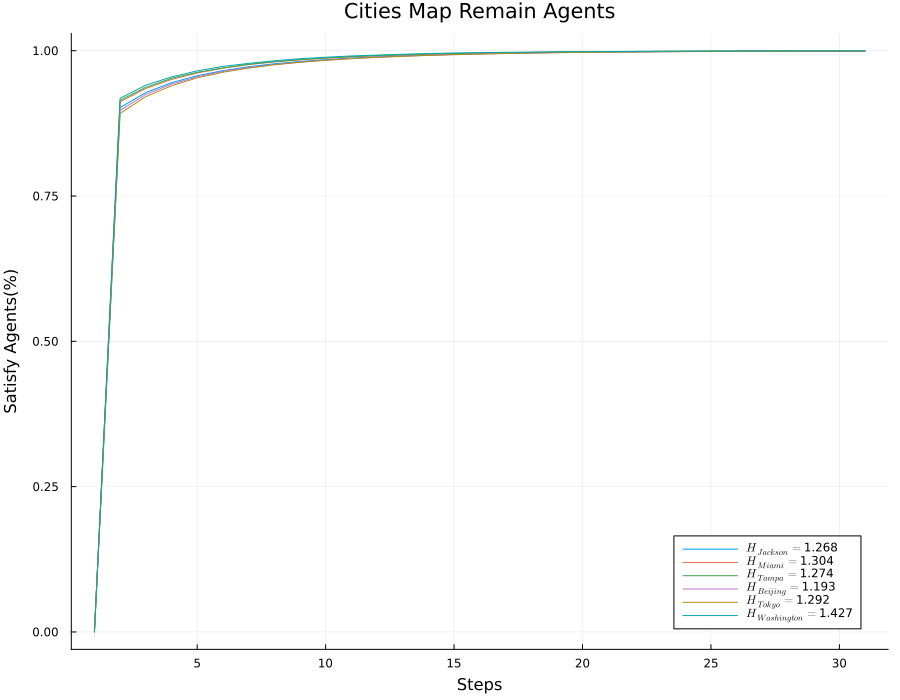

In [201]:
p11 = Plots.plot(city_map_remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, lw=1,
    title="Cities Map Remain Agents", size=(900, 700),left_margin = 2Measures.mm )
savefig("./plots/Fig11remainAllCities.pdf")
display(p11)

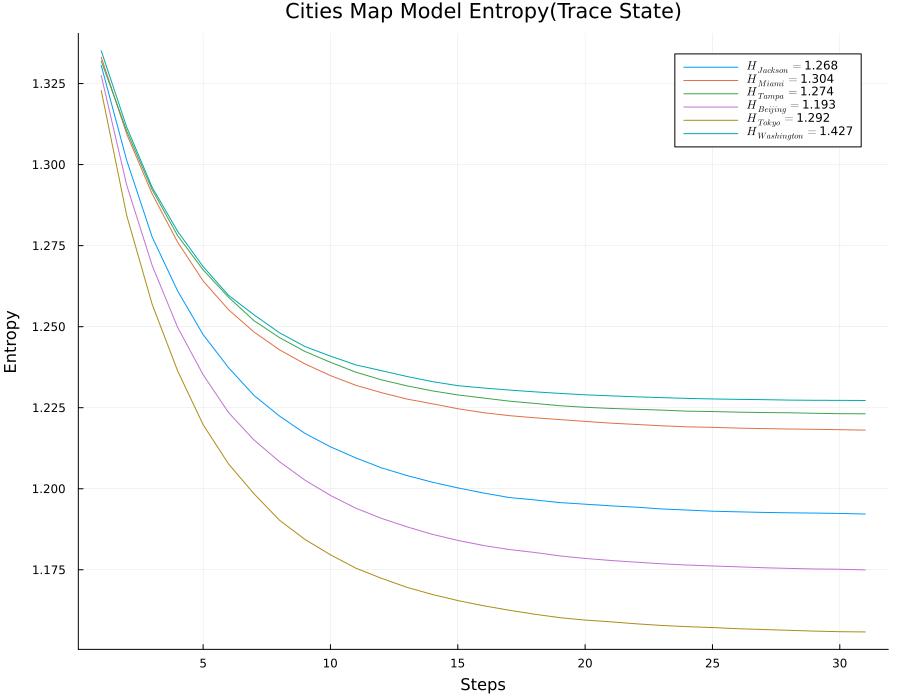

In [202]:
p12 = Plots.plot(city_map_gb_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr, lw=1,
    title="Cities Map Model Entropy(Trace State)", size=(900, 700),left_margin = 2Measures.mm )
savefig("./plots/Fig12entropyAllCities.pdf")
display(p12)

### Model Visualize Set up  - Node size, shape & color

In [62]:
function VertexFillColors(graph, model)    
    vertex_colors = [ RGB(0, 0, 0) for i in 1:nv(graph) ]
    
    for agent in model.agents
        
        if( agent.group == 1 )
            vertex_colors[ agent.pos ] = RGB(1, 0.65, 0)
        else 
            vertex_colors[ agent.pos ] = RGB(0, 0, 1)
        end        
    end
    
    return vertex_colors
end

VertexFillColors (generic function with 1 method)

In [63]:
# Shape: Square means satisfy, circle means not

function VertexShape(graph, model)    
    vertex_shape = [:circle for i in 1:nv(graph)]
    
    for agent in model.agents
        
        if( agent.remain==true)
            vertex_shape[ agent.pos ] = :square
        else 
            vertex_shape[ agent.pos ] = :circle
        end        
    end
    
    return vertex_shape
end

VertexShape (generic function with 1 method)

### Visualize Graph after Steps

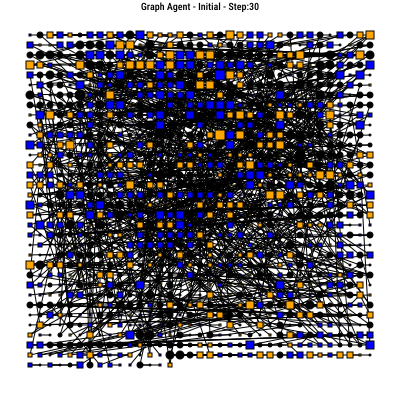

In [64]:
model = initialize(miami_graph)

step_num = 30
Agents.step!(model, agent_step!, step_num)
pic = @drawsvg begin
    background("white")
    drawgraph(miami_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(miami_graph, model),
        vertexshapesizes = [Graphs.outdegree(miami_graph, v) for v in Graphs.vertices(miami_graph)],
        vertexfillcolors = VertexFillColors(miami_graph, model) )
    Karnak.text( "Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
end 400 400
#miami 30 steps with scalling agents on connectivity and square is satisfied agents and circle otherwise
#subset of miami graph is (1170 number of nodes, 1451 number of edges) 75 of agents

In [65]:
@pdf begin
    background("white")
    drawgraph(miami_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(miami_graph, model),
        vertexshapesizes = [Graphs.outdegree(miami_graph, v) for v in Graphs.vertices(miami_graph)],
        vertexfillcolors = VertexFillColors(miami_graph, model) )
    Karnak.text( "Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
    end 1000 1000 "./plots/fig13miami30.pdf"

#### Different Layout using postion layout

In [66]:
keys_array = []
enu1_array = []
enu2_array = []
nodeID_array = []
# Extract key and first two ENU values from the dataset
for key in miami_map_data.n
    push!(keys_array, key)
    push!(enu1_array, miami_map_data.nodes[key].east)
    push!(enu2_array, miami_map_data.nodes[key].north)
    push!(nodeID_array, miami_map_data.v[key])
end

# Create a DataFrame from the extracted data
df_miami = DataFrame(Key = keys_array,GraphID = nodeID_array, ENU1 = enu1_array, ENU2 = enu2_array);

In [67]:
miami_positions = @. Karnak.Point(df_miami.ENU1,df_miami.ENU2);

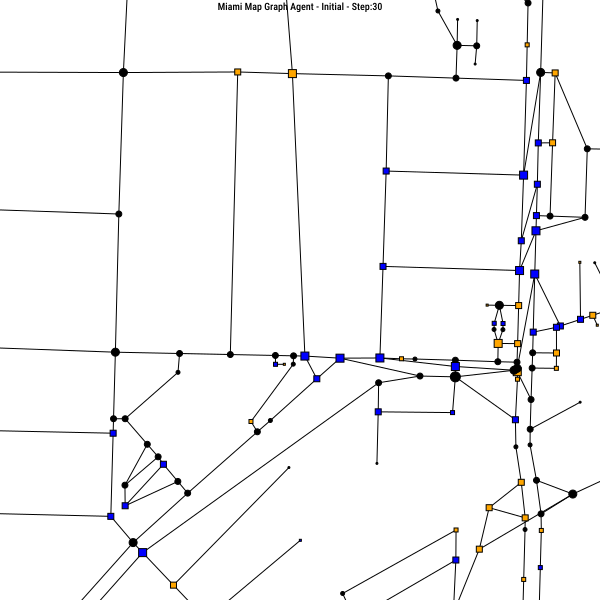

In [68]:

@drawsvg begin
    background("white")
    drawgraph(miami_graph, 
    layout = miami_positions,
    vertexshapes = VertexShape(miami_graph, model),
    vertexshapesizes = [Graphs.outdegree(miami_graph, v) for v in Graphs.vertices(miami_graph)],
    vertexfillcolors = VertexFillColors(miami_graph, model) )
    Karnak.text( "Miami Map Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
end

In [69]:

@pdf begin
    background("white")
    drawgraph(miami_graph, 
    layout = miami_positions,
    vertexshapes = VertexShape(miami_graph, model),
    vertexshapesizes = [Graphs.outdegree(miami_graph, v) for v in Graphs.vertices(miami_graph)],
    vertexfillcolors = VertexFillColors(miami_graph, model) )
    Karnak.text( "Miami Map Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
    end 1000 1000 "./plots/Fig14miamiZoomedIn.pdf"

### Save Pictures

In [70]:
# savefig(p1 , "./plots/EntropyUrbanRank.pdf")
# savefig(p2 , "./plots/EntropyUrbanRank.pdf")
# savefig(p3 , "./plots/RemainUrbanRank_Diff_statisfiction.pdf")
# savefig(p4 , "./plots/EntropyUrbanRank_Diff_statisfiction.pdf")
# savefig(p5 , "./plots/RemainUrbanRank_Diff_network.pdf")
# savefig(p6 , "./plots/EntropyUrbanRank_Diff_network.pdf")
# savefig(p7 , "./plots/RemainUrbanRank_Diff_capitalmap.pdf")
# savefig(p8 , "./plots/EntropyUrbanRank_Diff_capitalmap.pdf")
# savefig(p9 , "./plots/RemainUrbanRank_Diff_citymap.pdf")
# savefig(p10 , "./plots/EntropyUrbanRank_Diff_citymap.pdf")